# Prosper Loan Dataset
## by Alejandro Rodriguez Martinez

## Investigation Overview

The main questions that will be answered:    
    1 - Which are the features that brings Borrower's APR down?    
    2 - Which are the features that may be used to forecast individual's risk of loan default?

## Dataset Overview

This dataset contains information on loans given to individuals. Before cleaning there are 
- 113937 entries with 
- 81 variables each.      

For obvious reasons in order to put together a comprehensive **visual** analysis only a subset of those 81 features will be used

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb
from scipy.stats import norm
%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
loan = pd.read_csv('prosperLoanData.csv')
loan_clean = loan.copy()
loan_clean.drop_duplicates(inplace=True)
loan_clean = loan.drop('ProsperScore',axis=1)
for colnametoDrop in ['ListingKey','ListingNumber', 'LoanKey', 'LoanNumber']:
    loan_clean.drop(colnametoDrop,axis=1,inplace=True)
loan_clean.drop(['MemberKey','GroupKey'],axis=1,inplace=True)
columnsToKeep = ['EmploymentStatusDuration','CreditScoreRangeUpper','DelinquenciesLast7Years','RevolvingCreditBalance','AvailableBankcardCredit','LoanOriginalAmount','BorrowerAPR','LenderYield','DebtToIncomeRatio','EmploymentStatus','IsBorrowerHomeowner','LoanStatus','Term','IncomeRange','CreditGrade','ProsperRating (Alpha)']
loan_clean.drop([x for x in loan_clean.columns if x not in columnsToKeep],axis=1,inplace=True)
loan_clean['CreditGrade'].where(loan_clean['CreditGrade'].notna(),loan_clean['ProsperRating (Alpha)'],inplace=True)
loan_clean.drop('ProsperRating (Alpha)',axis=1,inplace=True)
loan_clean.CreditGrade.value_counts()
ordinal_var_dict = {'CreditGrade': ['NC','HR','E','D','C','B','A','AA'],
                    'Term':[12,36,60],
                    'IncomeRange':['Not displayed','Not employed','$0','$1-24,999','$25,000-49,999','$50,000-74,999','$75,000-99,999','$100,000+']}

for var in ordinal_var_dict:
    pd_ver = pd.__version__.split(".")
    if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ordinal_var_dict[var])
        loan_clean[var] = loan_clean[var].astype(ordered_var)
    else: # pre-v0.21
        loan_clean[var] = loan_clean[var].astype('category', ordered = True,
                                             categories = ordinal_var_dict[var])
loan_clean.EmploymentStatus.replace(np.nan,'Not available',inplace=True)
loan_clean.CreditGrade.replace(np.nan,'NC',inplace=True)
loan_clean.drop(loan_clean[loan_clean.AvailableBankcardCredit.isna()].index,axis=0,inplace=True)
colToFil = ['EmploymentStatusDuration', 'RevolvingCreditBalance', 'DelinquenciesLast7Years','DebtToIncomeRatio']
for col in colToFil:
    dummyValues = loan_clean.groupby('CreditGrade').mean().reset_index()[['CreditGrade',col]]
    valuesOnGrade = loan_clean[loan_clean[col].isna()].merge(dummyValues,how='left',on='CreditGrade')['{}_y'.format(col)]
    indexesToWrite = loan_clean[loan_clean[col].isna()].index
    loan_clean.loc[indexesToWrite,col] = valuesOnGrade.values
    loan_clean[loan_clean[col].isna()]
loan_clean.EmploymentStatusDuration = loan_clean.EmploymentStatusDuration.astype('int64')
loan_clean.CreditScoreRangeUpper = loan_clean.CreditScoreRangeUpper.astype('int64')
loan_clean.DelinquenciesLast7Years = loan_clean.DelinquenciesLast7Years.astype('int64')
loan_clean.RevolvingCreditBalance = loan_clean.RevolvingCreditBalance.astype('int64')
loan_clean.AvailableBankcardCredit = loan_clean.AvailableBankcardCredit.astype('int64')
loan_clean.LoanOriginalAmount = loan_clean.LoanOriginalAmount.astype('int64')
loan_clean.drop(loan_clean[loan_clean.CreditScoreRangeUpper < 250].index,axis=0,inplace=True)


## Features
These are the features that will be analysed. Please note the highligthed text in blue represent the variables of interest.

**Numerical Discrete**
- 'EmploymentStatusDuration' 
- 'CreditScoreRangeUpper'
- 'DelinquenciesLast7Years'
- 'RevolvingCreditBalance'
- 'AvailableBankcardCredit'
- 'LoanOriginalAmount'  

**Numerical Continuous**
- <span style="color:blue">'BorrowerAPR'</span>
- 'LenderYield'
- 'DebtToIncomeRatio'              

**Categorical/ Nominal**
- 'EmploymentStatus'    -  9 categories
- 'IsBorrowerHomeowner' - 2 categories
- <span style="color:blue">'LoanStatus'</span> - 12 categories    

**Ordinal**
- 'Term'
- 'IncomeRange'
- 'CreditGrade'                         
- 'ProsperRating (Alpha)'               

## First variable of interest
### BorrowerAPR

Inspecting this variable's distribution highlights a spike around 0.35 APR in what otherwise could be considered a slightly right skewed distribution.
The question posed above basically suggest we should find out the set of features that make APR be the lowest possible

In [3]:
def plothist(binsize,xvector,title,xlabel,ylabel,xlowlim,xhighlim,tickstep):
    binedges = np.arange(xlowlim,xhighlim+binsize,binsize)
    plt.hist(xvector,bins=binedges);
    plt.xticks(np.arange(xlowlim,xhighlim,tickstep));
    plt.title('Borrower APR histogram');
    plt.xlabel('APR (%)');
    plt.ylabel('Frequency');

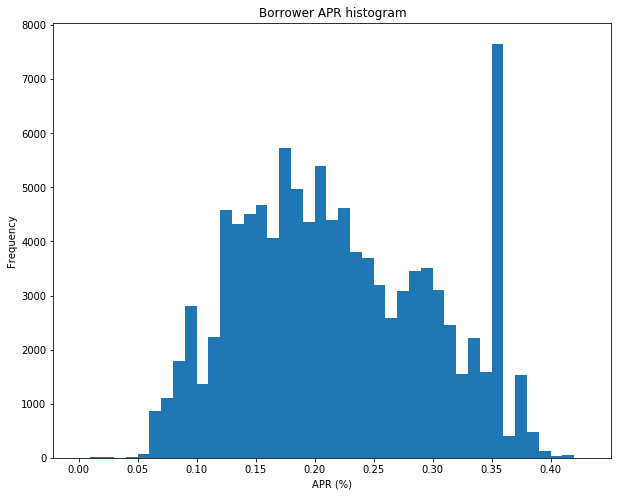

In [4]:
plt.figure(figsize=(10,8));
plothist(0.01,loan_clean['BorrowerAPR'],'Borrower APR histogram','APR (%)','Frequency',0,0.43,0.05)

## Second Variable of interest
### Loan Status

The following graph represents all possible categories for this variable. The second question can also be rephrased as, how can a financial instution find out which potential borrowers will fall under **Default** category

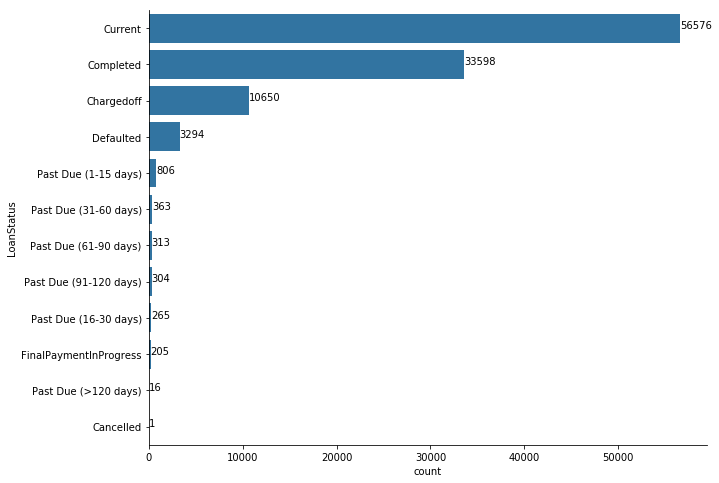

In [5]:
plt.figure(figsize=(10,8))
basecolor = sb.color_palette()[0]
nameorder = loan_clean.LoanStatus.value_counts().index
namevalue = loan_clean.LoanStatus.value_counts().values
sb.countplot(data=loan_clean,y='LoanStatus',color=basecolor,order=nameorder);
sb.despine()
for i,value in enumerate(namevalue):
    plt.text(value,i,value)

## Second Variable of interest (2)
### Loan Status

Some categories have very few entries and so since some refer to a loan being late on the payment, then join them together. Also, remove those categories that contain very little entries as they don't convey meaninful information

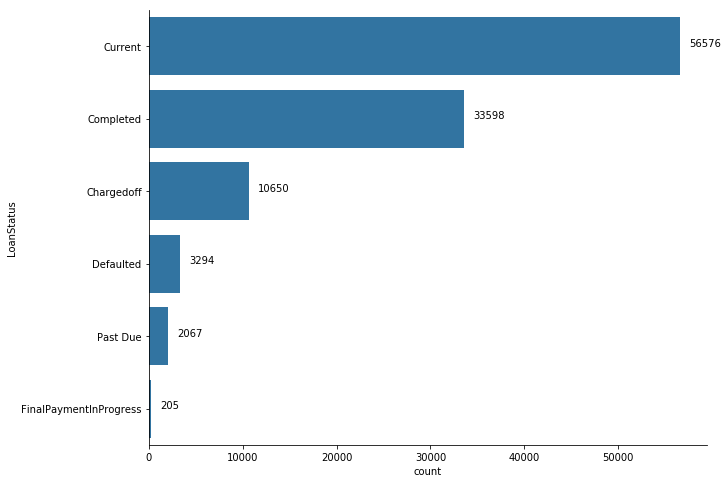

In [6]:
plt.figure(figsize=(10,8))
loan_clean.LoanStatus.replace(r'Past Due .+','Past Due',regex=True,inplace=True)
loan_clean.drop( loan_clean[loan_clean['LoanStatus'] == 'Cancelled'].index,axis=0,inplace=True)
nameorder = loan_clean.LoanStatus.value_counts().index
namevalue = loan_clean.LoanStatus.value_counts().values
sb.countplot(data=loan_clean,y='LoanStatus',color=basecolor,order=nameorder);
sb.despine()
for i,value in enumerate(namevalue):
    plt.text(value+1000,i,value)

In [7]:
loan_clean.drop(loan_clean[loan_clean['Term'].isin([12,60])].index,axis=0,inplace=True)
loan_clean.drop('Term',axis=1,inplace=True)
loan_clean.drop(['EmploymentStatus','EmploymentStatusDuration'],axis=1,inplace=True)
loan_clean.drop(loan_clean[loan_clean['IncomeRange'].isin(['Not displayed','Not employed','$0'])].index, axis=0, inplace=True )
# Rewrite IncomeRange category
ordinal_var_dict = {'IncomeRange':['$1-24,999','$25,000-49,999','$50,000-74,999','$75,000-99,999','$100,000+']}
for var in ordinal_var_dict:
    pd_ver = pd.__version__.split(".")
    if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ordinal_var_dict[var])
        loan_clean[var] = loan_clean[var].astype(ordered_var)
    else: # pre-v0.21
        loan_clean[var] = loan_clean[var].astype('category', ordered = True,
                                             categories = ordinal_var_dict[var])
loan_clean.drop(loan_clean[loan_clean['CreditGrade'] == 'NC'].index, axis=0, inplace=True )
# Rewrite IncomeRange category
ordinal_var_dict = {'CreditGrade':['HR','E','D','C','B','A','AA']}
for var in ordinal_var_dict:
    pd_ver = pd.__version__.split(".")
    if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ordinal_var_dict[var])
        loan_clean[var] = loan_clean[var].astype(ordered_var)
    else: # pre-v0.21
        loan_clean[var] = loan_clean[var].astype('category', ordered = True,
                                             categories = ordinal_var_dict[var])
loan_clean.drop(loan_clean[loan_clean['DebtToIncomeRatio'] > 10].index,axis=0,inplace=True)

## Bivariate analysis on APR
### vs numerical features

Very hard to see relationships with scatterplot.
Only AvailableBankcardCreditTrans seems to negatively correlate slightly with APR


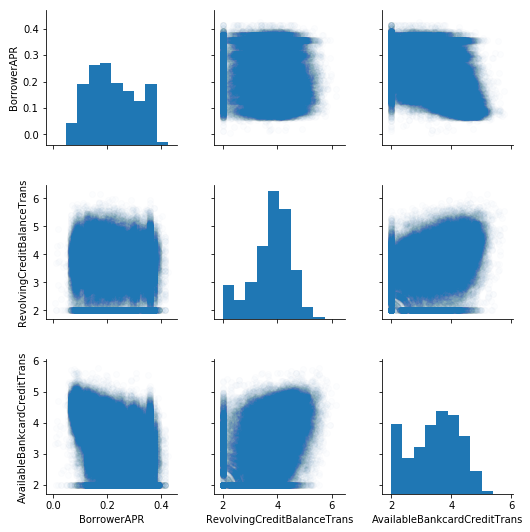

In [8]:
varsToScatter = loan_clean[['BorrowerAPR','CreditScoreRangeUpper','LenderYield','DebtToIncomeRatio']].copy()
varsToScatter['DebtToIncomeRatio'] = varsToScatter['DebtToIncomeRatio'].where(lambda x: x < 1, 1)
varsToScatter['DelinquenciesLast7YearsTrans'] = np.log10(loan_clean['DelinquenciesLast7Years'].where(lambda x: x >0, 1))
varsToScatter['RevolvingCreditBalanceTrans'] = np.log10(loan_clean['RevolvingCreditBalance'].where(lambda x: x > 100, 100))
#varsToScatter['AvailableBankcardCreditTrans'] = loan_clean['AvailableBankcardCredit'].where(lambda x: x < 100000, 100000)
varsToScatter['AvailableBankcardCreditTrans'] = np.log10(loan_clean['AvailableBankcardCredit'].where(lambda x: x>100,100))
g = sb.PairGrid(data=varsToScatter, vars = ['BorrowerAPR','RevolvingCreditBalanceTrans','AvailableBankcardCreditTrans']);
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter,alpha=0.01);

## Bivariate analysis on APR (2)
### vs numerical features

Similarly with features that don't require scaling. 
Only CreditScoreRangeUpper seems to correlate somehow.
Lender Yield shows a perfect correlation. Leads me to think that it's probably the same variable and no further analysis will be pursued

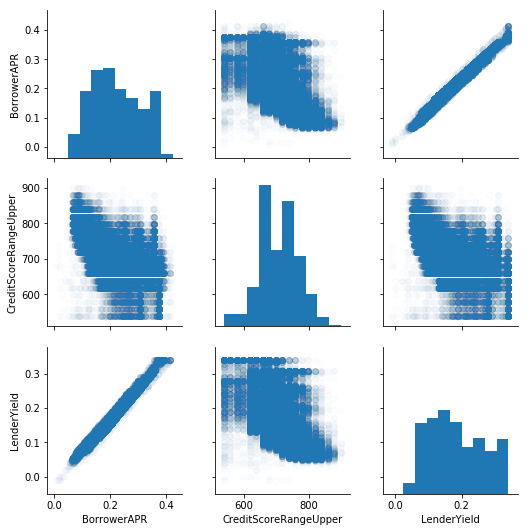

In [9]:
g = sb.PairGrid(data=varsToScatter, vars = ['BorrowerAPR','CreditScoreRangeUpper','LenderYield']);
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter, alpha=0.01);

## Bivariate analysis on APR (3)
### vs numerical features

Lastly, none of the below features seems to share a strong correlation with BorrowerAPR

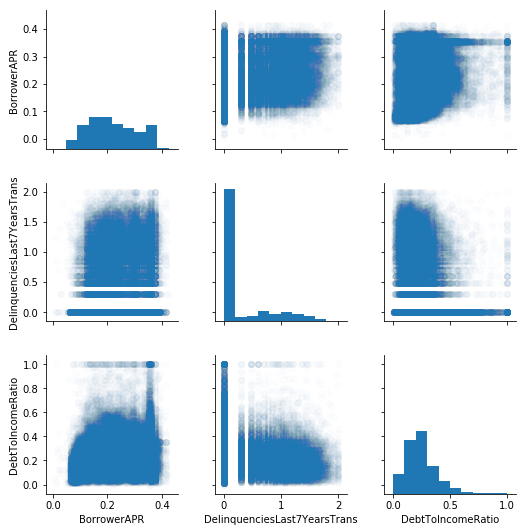

In [10]:
g = sb.PairGrid(data=varsToScatter, vars = ['BorrowerAPR','DelinquenciesLast7YearsTrans','DebtToIncomeRatio']);
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter, alpha=0.01);

## Bivariate analysis on APR (4)
### vs numerical features

Revolving credit balance didn't show any signs of relation when looking at the scatterplot.
However when represeting a heatmap a weak correlation can be inferred

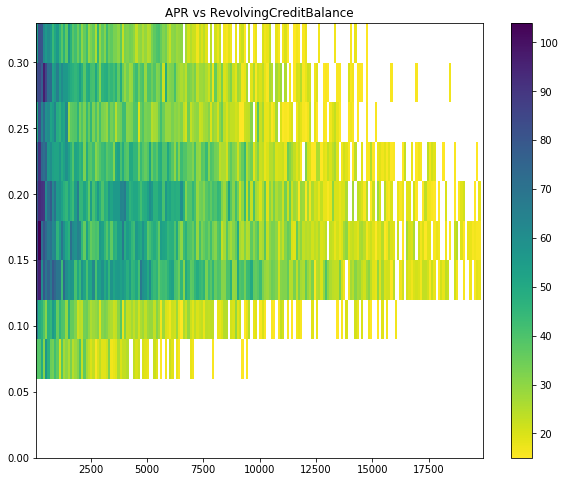

In [25]:
plt.figure(figsize=(10,8))
xstep = 100
binsx = np.arange(100,20000,xstep)
ystep = 0.03
binsy = np.arange(0,0.32+ystep,ystep)
plt.hist2d(data = varsToScatter, x = loan_clean['RevolvingCreditBalance'],y = 'BorrowerAPR',bins = [binsx, binsy], cmap = 'viridis_r', cmin = 15);
plt.colorbar()
plt.title('APR vs RevolvingCreditBalance');

## Bivariate analysis on APR (5)
### vs categorical features

Let's see how APR relates to the categorical features. The graph below seems to suggest that there is a dependency between APR and home owner

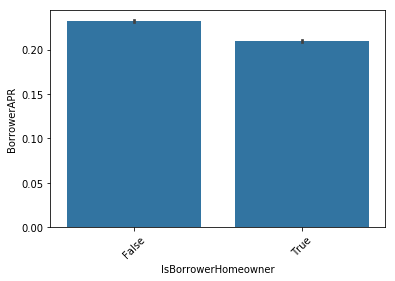

In [24]:
sb.barplot(data=loan_clean,x='IsBorrowerHomeowner', y='BorrowerAPR',color=basecolor);
plt.xticks(rotation=45);

## Bivariate analysis on APR (6)
### vs categorical features

The graph below makes clear that borrowerAPR is also affected by salary range and credit grade

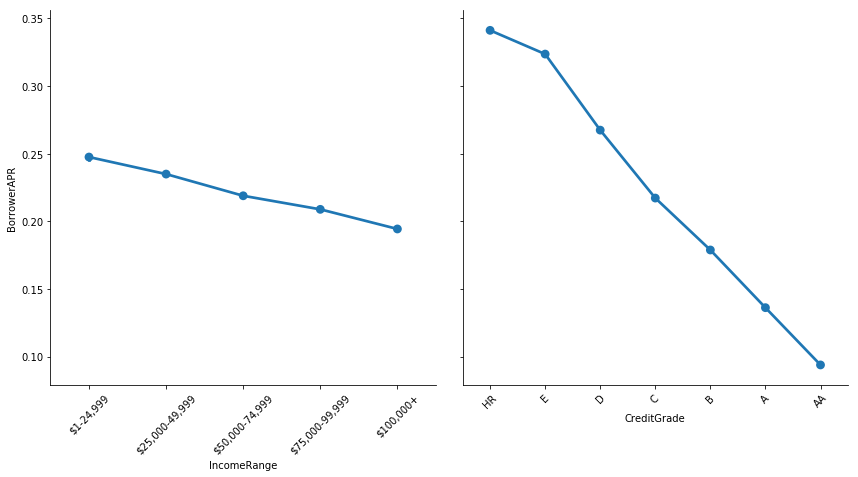

In [13]:
g = sb.PairGrid(data=loan_clean,x_vars=['IncomeRange','CreditGrade'], y_vars='BorrowerAPR',size=6)
g.map(sb.pointplot,color=basecolor)
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

## Bivariate analysis on APR (7)
### Conclusion

After this analysis it seems that if someone wants to get a loan and pay as little interest as possible, they should pay attention to the following features

- Credit Grade *(The higher rating the better)*
- Income Range *(The higher income the better)*
- Homeowner *(Owning a home is better)*
- Credit Score numerical *(The higher score the better)*
- Available bank card credit *(The higher available credit the better)*

To a lesser extent the borrower should pay attention to

- Debt to income ratio *(Less debt to income the better)*
- Loan original amount *(The bigger the loan the better)*

## Multivariate analysis on APR
### vs numerical features

Let's now verify that the relations we found before still hold with a multivariate analysis.
In the plot below all features that we found had some relation are plotted.
Color represents the APR, so a potential borrower should chose the values of the features in the plot where the color is dark blue

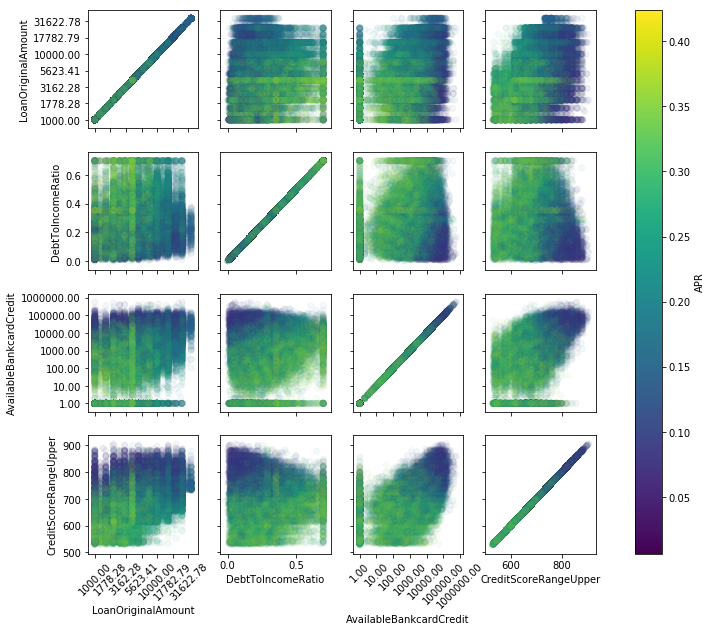

In [41]:
loan_clean_4 = loan_clean[['LoanOriginalAmount','DebtToIncomeRatio','AvailableBankcardCredit','CreditScoreRangeUpper']].copy()
loan_clean_4['LoanOriginalAmount'] = np.log10(loan_clean_4['LoanOriginalAmount'])#.where(lambda x: x <30000, 30000)
loan_clean_4['DebtToIncomeRatio'] = loan_clean_4['DebtToIncomeRatio'].where(lambda x: x <0.7, 0.7)
loan_clean_4['AvailableBankcardCredit'] = np.log10(loan_clean_4['AvailableBankcardCredit'].where(lambda x: x >0, 1))
randcr= 4 * np.random.randn(loan_clean_4.shape[0])
loan_clean_4['CreditScoreRangeUpper'] = loan_clean_4.CreditScoreRangeUpper + randcr
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(14, 10),squeeze=False,sharey='row',sharex='col')
ima = []
for i,col1 in enumerate(loan_clean_4.columns):
    for j,col2 in enumerate(loan_clean_4.columns):
        ima.append(axs[i][j].scatter(loan_clean_4[col2],loan_clean_4[col1],alpha=0.05, c = loan_clean['BorrowerAPR'] ))
        if j == 0:
            axs[i][j].set_ylabel(col1)
            mytic = []
            if i == 0:
                mytic = np.arange(3,4.6,0.25)
            if i == 2:
                mytic = np.arange(0,6.2,1)
            if len(mytic) > 0:
                axs[i][j].set_yticks(mytic)
                axs[i][j].set_yticklabels(["{0:.2f}".format(10**i) for i in mytic]) 
        if i == 3:
            axs[i][j].set_xlabel(col2)
            mytic = []
            if j == 0:
                mytic = np.arange(3,4.6,0.25)
            if j == 2:
                mytic = np.arange(0,6.2,1)
            if len(mytic) > 0:
                axs[i][j].set_xticks(mytic)
                axs[i][j].set_xticklabels(["{0:.2f}".format(10**i) for i in mytic],rotation=45) 

norm = colors.Normalize(vmin= loan_clean['BorrowerAPR'].min(), vmax= loan_clean['BorrowerAPR'].max())
for im in ima:
    im.set_norm(norm)
color_bar = fig.colorbar(ima[1], ax=axs, orientation='vertical', fraction=.3)
color_bar.set_alpha(1)
color_bar.draw_all()
color_bar.set_label('APR')

## Multivariate analysis on APR (2)
### vs categorical features

When looking at the top two subplots, one could think that there is something counter intuitive in that higher salaries receive higher interest. This would suggest that someone needs to earn as little as possible. When analyse together with for example original amount then we can understand why. The thing is that people with higher salaries tend to borrow more money hence increasing the risk. See below

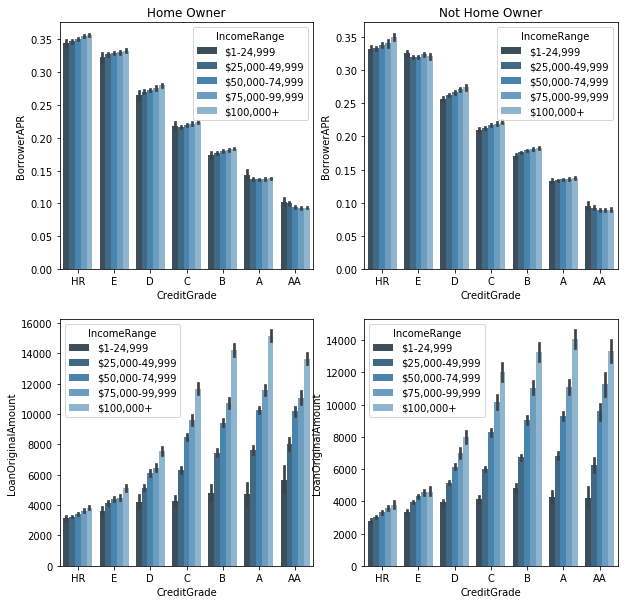

In [40]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),squeeze=False,sharey='row',sharex='col');
plt.subplot(2,2,1)
sb.barplot(data= loan_clean[loan_clean['IsBorrowerHomeowner']==True],x='CreditGrade',y='BorrowerAPR',hue='IncomeRange',palette='Blues_d');
plt.title('Home Owner')
plt.subplot(2,2,2)
sb.barplot(data= loan_clean[loan_clean['IsBorrowerHomeowner']==False],x='CreditGrade',y='BorrowerAPR',hue='IncomeRange',palette='Blues_d');
plt.title('Not Home Owner')
plt.subplot(2,2,3)
sb.barplot(data= loan_clean[loan_clean['IsBorrowerHomeowner']==True],x='CreditGrade',y='LoanOriginalAmount',hue='IncomeRange',palette='Blues_d');
plt.subplot(2,2,4)
sb.barplot(data= loan_clean[loan_clean['IsBorrowerHomeowner']==False],x='CreditGrade',y='LoanOriginalAmount',hue='IncomeRange',palette='Blues_d');

## Multivariate analysis on APR (3)
### Conclusion
So after multivariate analysis it seems clear that **credit grade** does make a difference to APR. However **owning a home** or **salary range** are less important when predicting the APR that a borrower may get.

So overall it seems that a potential borrower should pay attention primarily to improving their credit grade as well as increasing the **available credit** on their cards. From all the parameters analyzed these seem to be the most important in defining the APR.

To a lesser extent, the borrower would prefer to own a home and get a loan that is not too small in quantity.

## Bivariate analysis on Loan Status
### vs numerical features

The financial institution will be interested in knowning whether an individual is likely to default on their loans. Let's start with relationships with numerical features.    

Below it can be observed that delinquencies over the last 7 years is not a good indicator of loan default. Loan Original Amount does not seem to be a good indicator either. However similar to APR, credit score, available bank card credit and debt to income ratio seem better features to include in the analysis


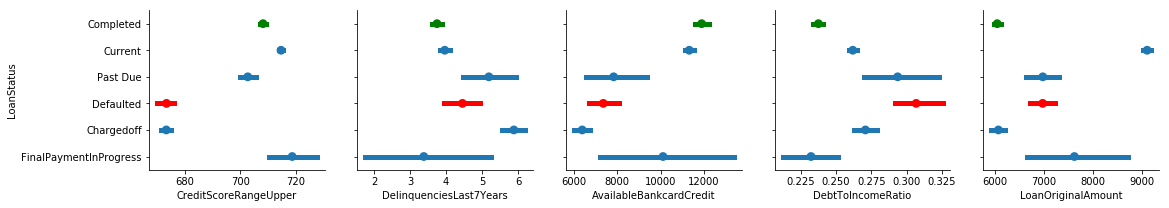

In [39]:
g=sb.PairGrid(data=loan_clean, x_vars=['CreditScoreRangeUpper', 'DelinquenciesLast7Years', 'AvailableBankcardCredit','DebtToIncomeRatio','LoanOriginalAmount'], y_vars=['LoanStatus']);
g.map(sb.pointplot,palette=['green',basecolor,basecolor,'red',basecolor,basecolor,basecolor],errwidth=5,ci=99);

## Bivariate analysis on Loan Status (2)
### vs categorical variable

What happens when comparing loan status vs home owner
It seems that homeowners are much likely to default than non-homeowners. Let's look at the graph

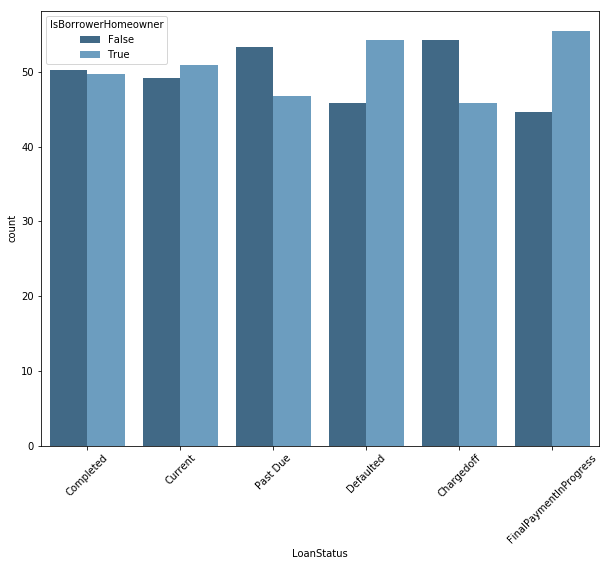

In [30]:
plt.figure(figsize=(10,8))
df = loan_clean[['IsBorrowerHomeowner','LoanStatus']].copy()
df['count'] = 1
df = df.groupby(['LoanStatus','IsBorrowerHomeowner']).count()
df = df.unstack(0).fillna(0)
df = df.apply(axis=0,func = lambda x: 100 * x / float(x.sum()))
df = df.stack()
df = df.reset_index()
sb.barplot(data=df,x='LoanStatus', y='count', hue='IsBorrowerHomeowner',order=['Completed','Current','Past Due','Defaulted','Chargedoff','FinalPaymentInProgress'],palette='Blues_d');
plt.xticks(rotation=45);

## Bivariate analysis on Loan Status (3)
### vs categorical variable

Salary range, does not seem to be an indicator of loan default as the graph below suggests. The proportions of incomes seem to be very similar for the two categories of interest, that is **Completed** and **Defaulted**

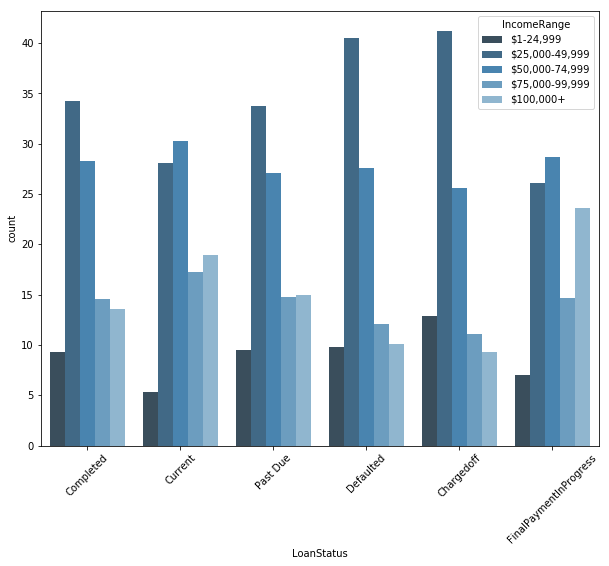

In [31]:
plt.figure(figsize=(10,8))
df = loan_clean[['IncomeRange','LoanStatus']].copy()
df['count'] = 1
df = df.groupby(['LoanStatus','IncomeRange']).count()
df = df.unstack(0).fillna(0)
df = df.apply(axis=0,func = lambda x: 100 * x / float(x.sum()))
df = df.stack()
df = df.reset_index()
df = df.drop(df[df['LoanStatus'] == 'Cancelled'].index,axis=0)
sb.barplot(data=df,x='LoanStatus', y='count', hue='IncomeRange',order=['Completed','Current','Past Due','Defaulted','Chargedoff','FinalPaymentInProgress'],palette='Blues_d');
plt.xticks(rotation=45);

## Bivariate analysis on Loan Status (4)
### vs categorical variable

On the other hand credit grades of AA and A seems to indicate a higher probability of repay

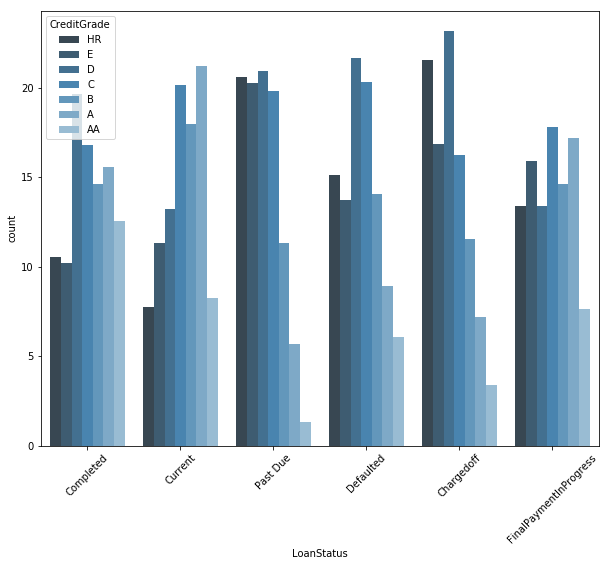

In [32]:
plt.figure(figsize=(10,8))
df = loan_clean[['CreditGrade','LoanStatus']].copy()
df['count'] = 1
df = df.groupby(['LoanStatus','CreditGrade']).count()
df = df.unstack(0).fillna(0)
df = df.apply(axis=0,func = lambda x: 100 * x / float(x.sum()))
df = df.stack()
df = df.reset_index()
df = df.drop(df[df['LoanStatus'] == 'Cancelled'].index,axis=0)
sb.barplot(data=df,x='LoanStatus', y='count',hue='CreditGrade',order=['Completed','Current','Past Due','Defaulted','Chargedoff','FinalPaymentInProgress'],palette='Blues_d');
plt.xticks(rotation=45);

## Bivariate analysis on Loan Status (6)
### Conclusion

After this analysis it seems that a financial institution should pay attention to the following features:

- Credit Score numerical
- Available bank card credit
- Debt to income ratio
- Whether or not they own a home 
- Credit Score ordinal

Let's see whether these features strengthen each othen when doing multivariate analysis

## Multivariate analysis on Loan Status
### Available bank card credit and debt to income ratio

These two features can identify some potential borrowers that are likely to default on their loans. See below how there are areas that are only occupied with squares that belong to default only

In [33]:
def heatmapNormalize(xvec,yvec,binsx,binsy,ltitles,suptitle, norm=True, cminThres=0.5,xlog=False,ylog=False):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    fig.suptitle(suptitle,fontsize=16)
    images = []
    len1 =len(xvec[0])
    len2 =len(xvec[1])
    ratio = []
    ratio.append( cminThres if len1/len2 < 1 else np.floor(len1/len2) + cminThres)
    ratio.append( cminThres if len2/len1 < 1 else np.floor(len2/len1) + cminThres)
    for j in range(2):
        # Generate data with a range that varies from one plot to the next.
        _,_,_,d = axs[j].hist2d(x=xvec[j],y=yvec[j],bins=[binsx,binsy], cmap = 'viridis_r',cmin=ratio[j])
        axs[j].set_title(ltitles[j])
        images.append(d)
        axs[j].label_outer()
        if xlog:
            axs[j].set_xscale('log')
        if ylog:
            axs[j].set_yscale('log')

    # Since both subplots may have different number of points, calculate ratios
    if norm:
        for image in images:
            arr = image.get_array()/image.get_array().sum()
            image.set_array(arr*100) # in percentage points

    vmin = min(image.get_array().min() for image in images)
    vmax = max(image.get_array().max() for image in images)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for im in images:
        im.set_norm(norm)
    fig.colorbar(images[1], ax=axs, orientation='vertical', fraction=.1)


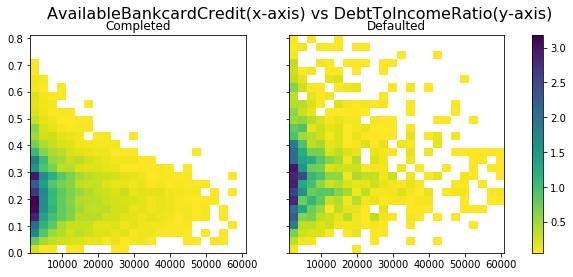

In [34]:
df_compl = loan_clean[loan_clean['LoanStatus']=='Completed' ].copy()
df_def = loan_clean[loan_clean['LoanStatus']=='Defaulted' ].copy()
xstep = 2500
binsx = np.arange(1000,60000+xstep,xstep)
ystep = 0.03
binsy = np.arange(0,0.8+ystep,ystep)
subplottitle =['Completed','Defaulted']
suptitle = 'AvailableBankcardCredit(x-axis) vs DebtToIncomeRatio(y-axis)'
heatmapNormalize([df_compl['AvailableBankcardCredit'], df_def['AvailableBankcardCredit']],[df_compl['DebtToIncomeRatio'], df_def['DebtToIncomeRatio']],binsx,binsy,subplottitle,suptitle,cminThres=0.5)

## Multivariate analysis on Loan Status (2)
### Available bank card credit and credit score numerical

Though to a lesser degree, the plot below also highlight areas where a financial institution can identify potential defaults

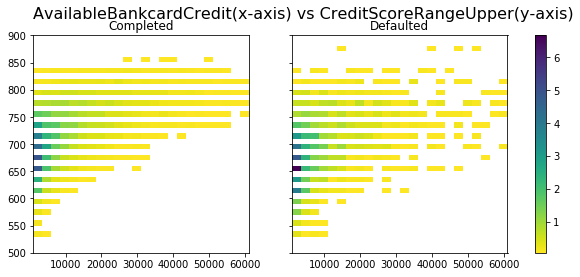

In [42]:
xstep = 2500
binsx = np.arange(1000,60000+xstep,xstep)
ystep = 10
binsy = np.arange(500,900+ystep,ystep)
subplottitle =['Completed','Defaulted']
suptitle = 'AvailableBankcardCredit(x-axis) vs CreditScoreRangeUpper(y-axis)'
heatmapNormalize([df_compl['AvailableBankcardCredit'], df_def['AvailableBankcardCredit']],[df_compl['CreditScoreRangeUpper'], df_def['CreditScoreRangeUpper']],binsx,binsy,subplottitle,suptitle,cminThres=0.5)

## Multivariate analysis on Loan Status (2)
### Categorical features and numerical

Below it can be seen that home owner feature is statistically significant and can be used in conjunction with other numerical features to assess the probability that an individual will default on their loans

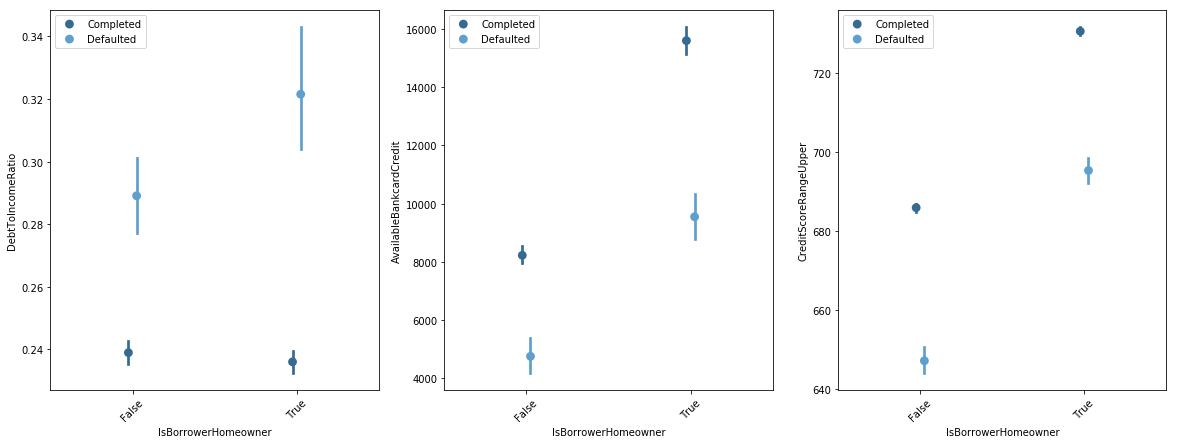

In [23]:
loan_clean_2 = loan_clean[ loan_clean['LoanStatus'].isin(['Completed','Defaulted']) ].copy()
numeric_list = ['DebtToIncomeRatio','AvailableBankcardCredit','CreditScoreRangeUpper']
plt.figure(figsize=(20,7))
for i,var in enumerate(numeric_list):
    plt.subplot(1,3,i+1)
    sb.pointplot(data=loan_clean_2, x='IsBorrowerHomeowner', y=var,hue='LoanStatus',palette='Blues_d',dodge=True,join=False)
    plt.xticks(rotation=45)
    plt.legend()

## Multivariate analysis on Loan Status (3)
### Conclusion

A financial institution should be looking at **credit score** and **available bankcard credit** in conjunction with **homeowner** to get a feel for whether a person may default on a loan.

**Debt to income ratio** seems not as a good predictor as the ones mentioned previously. Also when combining any of the relevant numerical features, namely availablebankcardcredit, creditscore and debttoincomeratio, it is possible to find out whether an individual falls under an area of perceived high risk as the heatmaps have shown

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:

> > cd DataScience\DataVisualization\LoanDataVisuals
> > `jupyter nbconvert slide_deck_template.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!